# Basic Models in TensorFlow

## Agenda
* Liner regression in TensorFlow
* Optimizers
* Logistic regression on MNIST
* Loss functions

## 振り返り
### graphの計算
* TensorFlowは計算の定義とその実行を分けている
    * Phase1: graph を組み立てる
    * Phase2: graphの演算を実行するために、sessionを使用する

In [1]:
# TensorBoardはFileWriterオブジェクトを生成することでgraphをevent fileに書き出すことができる

import tensorflow as tf
a = 2 
b = 3 
x = tf.add(a, b)
y = tf.multiply(a, b)
useless = tf.multiply(a, x)
z = tf.pow(y, x)
with tf.Session() as sess:
    z = sess.run(z)

### tf.constant と tf.Variables
* Constant valueがgraph定義にストアされる
* Sessionはストアする変数にメモリを割り当てる

### tf.placeholder と feed_dict
* 値を辞書型によってplaceholderに与えることができる
* variablesにも同様に入れることができる

### Lazy loading を避ける
* graphの組み立てとopsの実行を分ける
* 関数が呼び出された際の一度だけloadされることを保証するためにPythonのattributeを使用する

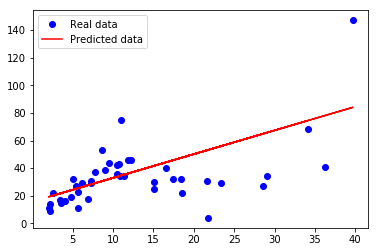

In [2]:
"""
Simple linear regression example in TensorFlow
This program tries to predict the number of thefts from 
the number of fire in the city of Chicago
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

DATA_FILE = '../data/fire_theft.xls'

# Phase 1: Assemble the graph
# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# Step 2: create placeholders for input X (number of fire) and label Y (number of theft)
X = tf.placeholder(tf.float32, name="X")
Y = tf.placeholder(tf.float32, name="Y")

# Step 3: create weight and bias, initialized to 0
# name your variables w and b
w = tf.Variable(0.0, name="weight") 
b = tf.Variable(0.0, name="bias")

# Step 4: predict Y (number of theft) from the number of fire
# name your variable Y_predicted
Y_predicted = X * w + b

# Step 5: use the square error as the loss function
# name your variable loss
loss = tf.square(Y - Y_predicted, name="loss")

# Step 6: using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
 
# Phase 2: Train our model
with tf.Session() as sess:
    #writer = tf.summary.FileWriter('./my_graph/03/liner_reg', sess.graph)
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('./my_graph/03/linear_reg', sess.graph)
    # Step 8: train the model
    for i in range(100): # run 100 epochs
        total_loss = 0
        for x, y in data:
            # Session runs optimizer to minimize loss and fetch the value of loss
            _, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y})
            total_loss += l
        #print("Epoch {0}: {1}".format(i, total_loss/n_samples))
    w, b = sess.run([w, b])

# plot the results
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w + b, 'r', label='Predicted data')
plt.legend()
plt.show()

## Discussion question
1. モデルの正しさをどうやって知るか？
2. モデルをどうやって改善するか？

上のoutputではあまりfitしていないように見える。。


## Huber loss
* ロバスト推定での回帰や、サポートベクトル回帰の損失関数として利用される。xが0から遠いところでは線形にしか増加しないため、はずれ値の影響が2次の損失関数と比べてずっと小さい。また、絶対損失と異なり、定義域全体で微分可能なため便利。

In [3]:
# Huber loss 関数
def huber_loss(labels, predictions, delta=1.0):
    residual = tf.abs(predictions - labels)
    condition = tf.less(residual, delta)
    small_res = 0.5 * tf.square(residual)
    large_res = delta * residual - 0.5 * tf.square(delta)
    return tf.where(condition, small_res, large_res)

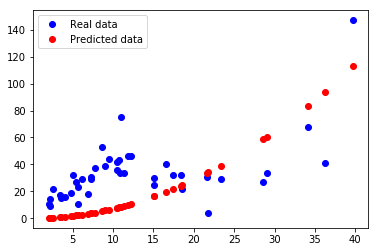

In [4]:
"""
quadratic function(二次関数)だとうまくいくだろうか?
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

DATA_FILE = '../data/fire_theft.xls'

# Phase 1: Assemble the graph
# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# Step 2: create placeholders for input X (number of fire) and label Y (number of theft)
X = tf.placeholder(tf.float32, name="X")
Y = tf.placeholder(tf.float32, name="Y")

# Step 3: create weight and bias, initialized to 0
# name your variables w and b
w = tf.Variable(0.0, name="weights_1")
u = tf.Variable(0.0, name="weights_2")
b = tf.Variable(0.0, name="bias")

# Step 4: predict Y (number of theft) from the number of fire
# name your variable Y_predicted
Y_predicted = X * X * w + X * u + b

# Step 5: use the square error as the loss function
# name your variable loss
# Huber lossを使用する場合、
# Y - Y_predicted < delta の場合には描画できない
loss = tf.square(huber_loss(Y, Y_predicted, delta=0.01), name="loss")

# Step 6: using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
 
# Phase 2: Train our model
with tf.Session() as sess:
    #writer = tf.summary.FileWriter('./my_graph/03/liner_reg', sess.graph)
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())
    
    #writer = tf.summary.FileWriter('./my_graph/03/linear_reg', sess.graph)
    # Step 8: train the model
    for i in range(10): # run 10 epochs
        total_loss = 0
        for x, y in data:
            # Session runs optimizer to minimize loss and fetch the value of loss
            _, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y})
            total_loss += l
        #print("Epoch {0}: {1}".format(i, total_loss/n_samples))
    w, u, b = sess.run([w, u, b])

# plot the results
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * X * w + X * u + b, 'ro', label='Predicted data')
plt.legend()
plt.show()

線形関数よりも少ない回数で収束しました。しかし、まだ異常値のため完全ではありません。もしかしたら、関数fとしてMSEや3rd degree polynomialの代わりにHuber lossの方がよいのかもしれません。

2次関数モデルにHuber lossを使用することで、異常値の無視が少しだけよくなりました。

### モデルの正しさをどうやって知るか？
#### R2乗の相関係数を使用する
あなたが`R-squared`を知らないのであれば、Minitabが[blog post](http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)で説明してくれています。

要点を言うと、
R-squared はデータがどの程度回帰線にフィットされているかの統計的尺度です。

それは決定係数または重回帰の寄与率(重相関係数)として知られている。

R-squaredの定義は直線的である。それは線形モデルによって説明されるresponse variable variationのパーセンテージである。

```
R-squared = Explined variation / Total Variation
```

#### テストセットを実行する
私達はvalidationやtestingに帰着する機械学習のクラスを学んでいます。そのため、最初のメソッドは私達のテストセット上のテストモデルを明らかにすることである。
訓練用のデータセットを別で持ち、検証し、テストをすることは素晴らしい。しかし、これは私達の訓練用データが不足する可能性があることを意味する。多くの文献が、k-fold cross validationのように、多くの予備のデータを持っていない場合に直面した場合の助けとなる。

#### ダミーデータでモデルをテストする
別の方法として、ダミーデータでテストを行うことがあげられる。例えば、今回の場合、モデルをテストするために私達が既に知っている線形な相関を持ったダミーデータをいくつか作成できる。今回、Y = 3 * X を満たす100のデータ点(X, Y)を作成しましょう。そして、モデルのアウトプットが w =3, b = 0かどうかを見てみましょう。

ダミーデータを生成する：

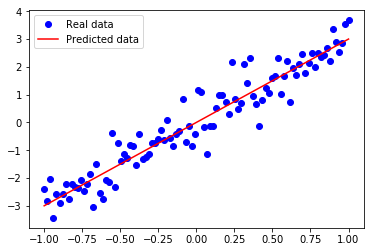

In [5]:
import numpy as np

X_input = np.linspace(-1, 1, 100)
Y_input = X_input * 3 + np.random.randn(X_input.shape[0]) * 0.5

# plot the results
X, Y = X_input, Y_input
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * 3 + 0, 'r', label='Predicted data')
plt.legend()


plt.show()

#### analyze code
モデルのcodeはまさに直線的です。以下2行を除外します。

``` python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
sess.run(optimizer, feed_dict={X:x, Y:y})
```

これらに似たコードを初めて実行したことを覚えていて、とても混乱しました。2つの疑問があります。
1. なぜ、tf.Session.run()のフェッチリストにtarin_opがあるのか。
2. TensorFlowがどのようにして変数が更新されたことを知るのか。

Session.run()のフェッチとしてTensorFlowのopsを実装に渡すことができます。TensorFlowはこれらのopsが依存するgraphの部分を実行するでしょう。この場合、train_opがloss関数を最小化することを目的にしていて、lossは変数wとbに依存することがわかります。

graphから、大きなnode(GradientDecentOptimizer)がweight、bias、gradientsのつのnodeに依存していることがわかります。

## Optimizer

`GradientDecentOptimizer`(最急降下法オプティマイザ)は私たちの更新ルールが最急降下法であることを意味します。TensorFlowは自動で差分を計算し、loss関数の値を小さくするためにwやbの値を更新します。

デフォルトでは、optimizerはオブジェクト関数が依存するすべての訓練可能な変数を訓練します。もし、訓練する必要がない変数があった場合、trainableをFalseに設定してください。以下は変数global_stepにて訓練する必要がない例です。
共通の変数は、モデルが何回実行されたかを追うために、多くのTensorFlowのモデルで見ることができます。


In [6]:
import tensorflow as tf

global_step = tf.Variable(0, trainable=False, dtype=tf.int32)
learning_rate = 0.01 * 0.99 ** tf.cast(global_step, tf.float32)

increment_step = global_step.assign_add(1)

# learning_rateはtensorになる
optimizer = GradientDesentOptimizer(learning_rate)


NameError: name 'GradientDesentOptimizer' is not defined

optimizerに対して変数が線形に変化しているか確認することができる。
optimizer によって計算されたその勾配を修正することができる。

```
import tensorflow as tf

# create optimizer
optimizer = tf.GradientDecentOptimizer(learning_rate = 0.1)

# compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(loss, <list of variables>)

# grads_and_vars is a list of tuples (gradient, variable).
# Do whatever you need to the 'gradient' part, for example, subtract each them by 1.
subtracted_grads_and_vars = [(gv[0] - 1.0, gv[1]) for gv in grads_and_vars]

# ask the optimizer to apply the subtracted gradients.
optimizer.apply_gradients(subtracted_grads_and_vars)
```

## ロジスティック回帰
### MNIST
* X: 手書きの数字
* Y: 数字の値
画像は28 × 28ピクセルで、1次元のtensorは784。それぞれに正解データとしてのラベルがついている。

In [13]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Step1. mnist dataを読み込む
MNIST = input_data.read_data_sets("../data/mnist", one_hot=True)

# Step2. モデルのパラメータを定義する
learning_rate = 0.01
batch_size = 128
n_epochs = 25

# Step3: feature用のplaceholderとlabelを作成する
# MNIST画像は28 * 28 = 784 のshape
# そのため、1* 784 の tensor に置き換えることが可能
# それぞれの画像に対して10個のクラスが存在する。0-9の数字に対応している
# ラベルは one-hotなベクトルである。(1つだけ1が立つようになっている)
X = tf.placeholder(tf.float32, [batch_size, 784])
Y = tf.placeholder(tf.float32, [batch_size, 10])

# Step4: weightとbiasを作成する
# w はランダムな変数で初期化する。平均して0になるようになっている。標準偏差は0.01
# b は0で初期化する
# wのshapeはXとYの次元数に依存する。以下を満たす、 Y = tf.matmul(X, w)
# bのshapeはYに依存する
w = tf.Variable(tf.random_normal(shape=[784, 10], stddev=0.01), name="weights")
b = tf.Variable(tf.zeros([1, 10]), name="bias")

# Step5: X, w, bから Y を予測する
# softmax層を通じて、画像ラベルの確率の確率分布を返却する
# batch_size * 10 tensorはその数字である確率を表す
logits = tf.matmul(X, w) + b

# Step6: loss関数を定義する
# loss functionとしてのlogitsと一緒にsoftmaxのcross entropyを使用する
# cross entropyを計算することは, softmaxが内部で適用されていることを意味します
entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)
loss = tf.reduce_mean(entropy) # compute the mean over exampes in batch

# Step7: 訓練用のopを定義する
# gradient descentを使用する。larningrateは0.01を最小化コストとして適用する
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    writer = tf.summary.FileWriter('./my_graph/03/mnist', sess.graph)
    sess.run(init)
    n_batches = int(MNIST.train.num_examples / batch_size)
    for i in range(n_epochs): # modelをn_epoch回学習させる
        for _ in range(n_batches):
            X_batch, Y_batch = MNIST.train.next_batch(batch_size)
            sess.run([optimizer, loss], feed_dict={X: X_batch, Y:Y_batch})
    writer.close()
# 25 epoch施行後に0.35程度のlossであるべき

# モデルのテスト
    n_batches = int(MNIST.test.num_examples / batch_size)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = MNIST.test.next_batch(batch_size)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict={X:X_batch, Y:Y_batch})
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        # similar to numpy.count_nonzero(boolarray)
        total_correct_preds += sess.run(accuracy)
    print("Accuracy {0}".format(total_correct_preds/MNIST.test.num_examples))

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Accuracy 0.9102
